# Titanic Kaggle Challenge: Advanced Feature Engineering
This notebook is based on the advanced feature engineering tutorial for the Titanic dataset available on Kaggle. The tutorial focuses on creating new features to improve model performance.
For more details, you can refer to the original tutorial here:
https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410

In [298]:
# Add project root to sys.path so we can import custom modules from anywhere
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.utility import *

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#import score R², mean squared error, and mean absolute error
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV

In [299]:
root_folder = os.path.dirname(os.getcwd())
train_data = pd.read_csv(os.path.join(root_folder, 'data', 'titanic', 'train.csv'))
test_data = pd.read_csv(os.path.join(root_folder, 'data', 'titanic', 'test.csv'))

# Ajoute une colonne pour distinguer train/test
train_data['is_train'] = 1
test_data['is_train'] = 0
test_data['Survived'] = np.nan  # Ajoute la colonne Survived pour aligner les colonnes

# Fusionne les deux datasets
full_data = pd.concat([train_data, test_data], ignore_index=True)
full_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_train
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [300]:
# Calcule la colonne Deck à partir de Cabin (première lettre), sinon 'M' pour missing
full_data['Deck'] = full_data['Cabin'].str[0].fillna('M')

In [301]:
print('unique value of Deck column:', full_data['Deck'].unique())

unique value of Deck column: ['M' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


In [302]:
import string
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

In [303]:
import warnings
warnings.filterwarnings("ignore")
full_data['Title'] = full_data['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
full_data['Is_Married'] = 0
full_data.loc[full_data['Title'] == 'Mrs', 'Is_Married'] = 1

In [304]:
full_data['Family'] = extract_surname(full_data['Name'])
#calculate the Familly survival rate
family_survival_rate = full_data.groupby('Family')['Survived'].mean().reset_index()
family_survival_rate.columns = ['Family', 'Family_Survival_Rate']
full_data = full_data.merge(family_survival_rate, on='Family', how='left')
full_data['Survival_Rate_family'] = full_data['Family_Survival_Rate'].fillna(0)

In [305]:
# Utilise une regex pour ne garder que les valeurs numériques dans la colonne Ticket et retire les espaces
full_data['Ticket'] = full_data['Ticket'].str.replace(' ', '')
full_data['Ticket'] = full_data['Ticket'].str.extract('(\d+)')
full_data['Ticket'] = pd.to_numeric(full_data['Ticket'], errors='coerce')

In [306]:
preproc = DataFramePreprocessor(
        fill_strategy='fill',  # 'drop', 'fill', or 'none'
        fill_method='mean',
        encoding='onehot'
    )

drop_columns = ['Cabin']
id_params = full_data[drop_columns]

# Applique le preprocessing sur le DataFrame fusionné
full_data_clean = preproc.fit_transform(full_data.drop(columns=drop_columns))
print('shape of full_data_clean:', full_data_clean.shape)
print('shape of id_params:', id_params.shape)
full_data_clean.head()

# Sépare à nouveau en train et test
titanic_clean_train = full_data_clean[full_data['is_train'] == 1].copy()
titanic_clean_test = full_data_clean[full_data['is_train'] == 0].copy()
id_param_train = id_params[full_data['is_train'] == 1].copy()
id_param_test = id_params[full_data['is_train'] == 0].copy()

shape of full_data_clean: (1309, 2226)
shape of id_params: (1309, 1)


In [307]:
out = DataFramePreprocessor().dataset_overview(X=titanic_clean_train, corr_threshold=0.8)
print(out['colinear_pairs'])
out['stats']

[('Survived', 'Family_Survival_Rate', 0.9087000536790585), ('Survived', 'Survival_Rate_family', 0.9087000536790585), ('Family_Survival_Rate', 'Survival_Rate_family', 1.0)]


,variance,unique_values,nan_counts,dtype
PassengerId,66231.000000,891,0,int64
Survived,0.236772,2,0,float64
Pclass,0.699015,3,0,int64
Age,169.057680,89,0,float64
SibSp,1.216043,7,0,int64
...,...,...,...,...
Family_de Mulder,0.001122,2,0,bool
Family_de Pelsmaeker,0.001122,2,0,bool
Family_del Carlo,0.001122,2,0,bool
Family_van Billiard,0.001122,2,0,bool


In [308]:
print('column names of titanic_clean_train:', titanic_clean_train.columns.tolist())

column names of titanic_clean_train: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'is_train', 'Is_Married', 'Family_Survival_Rate', 'Survival_Rate_family', 'Name_Abbing, Mr. Anthony', 'Name_Abbott, Master. Eugene Joseph', 'Name_Abbott, Mr. Rossmore Edward', 'Name_Abbott, Mrs. Stanton (Rosa Hunt)', 'Name_Abelseth, Miss. Karen Marie', 'Name_Abelseth, Mr. Olaus Jorgensen', 'Name_Abelson, Mr. Samuel', 'Name_Abelson, Mrs. Samuel (Hannah Wizosky)', 'Name_Abrahamsson, Mr. Abraham August Johannes', 'Name_Abrahim, Mrs. Joseph (Sophie Halaut Easu)', 'Name_Adahl, Mr. Mauritz Nils Martin', 'Name_Adams, Mr. John', 'Name_Ahlin, Mrs. Johan (Johanna Persdotter Larsson)', 'Name_Aks, Master. Philip Frank', 'Name_Aks, Mrs. Sam (Leah Rosen)', 'Name_Albimona, Mr. Nassef Cassem', 'Name_Aldworth, Mr. Charles Augustus', 'Name_Alexander, Mr. William', 'Name_Alhomaki, Mr. Ilmari Rudolf', 'Name_Ali, Mr. Ahmed', 'Name_Ali, Mr. William', 'Name_Allen, Miss. Elisabeth Walton', 'Na

In [309]:
X = titanic_clean_train.drop(columns=['Survived', 'Parch', 'SibSp', 'is_train']) #'Embarked', 'SibSp', 'Parch', 'Ticket'
#drop all columns start with familly
all_columns = titanic_clean_train.columns.tolist()
drop_columns = [col for col in all_columns if col.startswith('Family')]
X = X.drop(columns=drop_columns)
X = X[['Survival_Rate_family', 'Title_Mr', 'Sex_female', 'Sex_male']]
y = titanic_clean_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [310]:
xgboost = XGBClassifier(
    n_estimators=100,       #  Number of trees
    max_depth=8,            # Maximum depth of a tree
    colsample_bytree=0.8,   # Subsample ratio of columns when constructing each tree
    gamma=0.3,                # Minimum loss reduction required to make a further partition on a leaf node  
    reg_lambda=2,           # L2 regularization term on weights
    objective='binary:logistic',  # Learning task and objective function
    )
xgboost.fit(X_train, y_train)
print("Train Accuracy:", xgboost.score(X_train, y_train))
print("Test Accuracy:", xgboost.score(X_test, y_test))

Train Accuracy: 0.9775280898876404
Test Accuracy: 0.9720670391061452


In [311]:
rfc = RandomForestClassifier(
    n_estimators=300,
    max_depth=7,
    min_samples_split=2,
    min_samples_leaf=6,
    oob_score =True,
)
rfc.fit(X_train, y_train)
print("Train Accuracy:", rfc.score(X_train, y_train))
print("Test Accuracy:", rfc.score(X_test, y_test))

Train Accuracy: 0.976123595505618
Test Accuracy: 0.9720670391061452


Text(0.5, 1.0, 'Feature Importances')

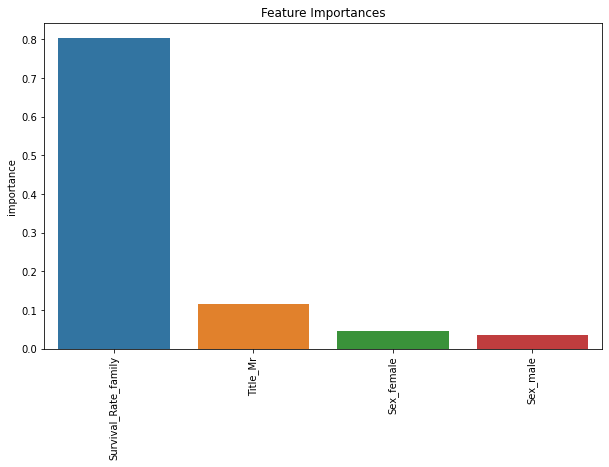

In [312]:
#display the feature importances
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index=X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)   
#plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.index, y=feature_importances['importance'])
plt.xticks(rotation=90)
plt.title('Feature Importances')

In [313]:
# top 10 features
top_features = feature_importances.head(10)
print('list of top 10 features:', top_features.index.tolist())

list of top 10 features: ['Survival_Rate_family', 'Title_Mr', 'Sex_female', 'Sex_male']


In [314]:
titanic_clean_test

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,is_train,Is_Married,...,Family_Zabour,Family_Zakarian,Family_Zimmerman,Family_de Brito,Family_de Messemaeker,Family_de Mulder,Family_de Pelsmaeker,Family_del Carlo,Family_van Billiard,Family_van Melkebeke
891,892,0.383838,3,34.500000,0,0,330911.0,7.8292,0,0,...,False,False,False,False,False,False,False,False,False,False
892,893,0.383838,3,47.000000,1,0,363272.0,7.0000,0,1,...,False,False,False,False,False,False,False,False,False,False
893,894,0.383838,2,62.000000,0,0,240276.0,9.6875,0,0,...,False,False,False,False,False,False,False,False,False,False
894,895,0.383838,3,27.000000,0,0,315154.0,8.6625,0,0,...,False,False,False,False,False,False,False,False,False,False
895,896,0.383838,3,22.000000,1,1,3101298.0,12.2875,0,1,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,0.383838,3,29.881138,0,0,5.0,8.0500,0,0,...,False,False,False,False,False,False,False,False,False,False
1305,1306,0.383838,1,39.000000,0,0,17758.0,108.9000,0,0,...,False,False,False,False,False,False,False,False,False,False
1306,1307,0.383838,3,38.500000,0,0,3101262.0,7.2500,0,0,...,False,False,False,False,False,False,False,False,False,False
1307,1308,0.383838,3,29.881138,0,0,359309.0,8.0500,0,0,...,False,False,False,False,False,False,False,False,False,False


In [315]:
feature_train = X_train.columns
print("Feature Train Shape:", feature_train)
X_test = titanic_clean_test[feature_train]
predictions_test = xgboost.predict(X_test)
final_answers = pd.DataFrame({
    'PassengerId': titanic_clean_test['PassengerId'],  # Use the PassengerId from the test set
    'Survived': predictions_test
})
#convert the PassengerId to int
final_answers['PassengerId'] = final_answers['PassengerId'].astype(int)
print("Final AnswersShape:", final_answers.shape)
final_answers.head()

Feature Train Shape: Index(['Survival_Rate_family', 'Title_Mr', 'Sex_female', 'Sex_male'], dtype='object')
Final AnswersShape: (418, 2)


,PassengerId,Survived
891,892,0
892,893,0
893,894,0
894,895,0
895,896,1


In [316]:
#save the final answers to a csv file
final_answers.to_csv(os.path.join(root_folder, 'data', 'titanic', 'final_answers.csv'), index=False)

- Current score public score is 0.78468 (best score in public leaderboard (legit score) is about 0.82 (top 2%)).
-  My score is 0.78468.~ 2383th place in public leaderboard the top 
- Top 
- Advanced feature engineering and model tuning can improve this score.


In [317]:
position = 2383
total_participants = 15257
percentile = (position / total_participants) * 100
print(f"Score public score is {percentile:.2f}% (best score in public leaderboard (legit score) is about 0.82 (top 2%)).")
print(f"My score is {percentile:.2f}%. ~ {position}th place in public leaderboard the top 2% of participants.")

Score public score is 15.62% (best score in public leaderboard (legit score) is about 0.82 (top 2%)).
My score is 15.62%. ~ 2383th place in public leaderboard the top 2% of participants.
